# Проект по А/B-тестированию

**Цель проекта** : проведение оценки результатов A/B-теста на основании действий пользователей, техническое задание и несколько вспомогательных датасетов.

**Задачи проекта**:

1) Оценить корректность проведения теста.

2) Проанализировать результаты теста.

**Техническое задание от заказчика**

1) Название теста: recommender_system_test;

2) Группы: А (контрольная), B (новая платёжная воронка);

3) Дата запуска: 2020-12-07;

4) Дата остановки набора новых пользователей: 2020-12-21;

5) Дата остановки: 2021-01-04;

6) Аудитория: 15% новых пользователей из региона EU;

7) Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

8) Ожидаемое количество участников теста: 6000.

9) Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:

- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase.

Для анализа заазчиком предоставлены следующие наборы данных:
- календарь маркетинговых событий на 2020 год
- данные о пользователях, зарегистрировавшихся в интернет-магазине в период с 7 по 21 декабря 2020 года
- события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
- таблица участников тестов


В рамках проекта будет выполнена:

1) Предобработка данных

2) Исследовательский анализ данных и оценка корректности выполнения теста

3) Оценка результатов А/В тестирования


## Загрузка данных

In [1]:
# импортируем необходимые бибилиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

import scipy.stats as stats
import numpy as np
import math as mth

from scipy import stats as st
from datetime import datetime, timedelta

In [2]:
#общий стиль визуализаций
plt.style.use('ggplot')
sns.set_palette('dark')

#общий стиль форматирования чисел
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# загрузим датафреймы
try:
    calendar = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    users = pd.read_csv('/datasets/final_ab_new_users.csv')
    events = pd.read_csv('/datasets/final_ab_events.csv')
    participants = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    calendar = pd.read_csv('https://???????/datasets/ab_project_marketing_events.csv')
    users = pd.read_csv('https://?????????/datasets/final_ab_new_users.csv')
    events = pd.read_csv('https://?????????/datasets/final_ab_events.csv')
    participants = pd.read_csv('https://?????????/datasets/final_ab_participants.csv')

In [4]:
# зададим кортеж, содежащий датафрейм и его название
df_list = ((calendar, 'calendar'),
           (users, 'users'),
           (events, 'events'),
           (participants, 'participants'))

In [5]:
#С помощью цикла для всех датафреймов выведем общую информацию, сведения о пропусках и дубликатах
for df, df_name in df_list:
    print(f'Название датафрейма {df_name}')
    display(df.head())
    display(df.info())
    print('=' * 40)
    print(f'Количество пропусков {df_name}:', df.isnull().sum())
    print(f'Количество дубликатов {df_name}:',df.duplicated().sum())
    print('=' * 40)
    print('\n')

Название датафрейма calendar


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

Количество пропусков calendar: name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Количество дубликатов calendar: 0


Название датафрейма users


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

Количество пропусков users: user_id       0
first_date    0
region        0
device        0
dtype: int64
Количество дубликатов users: 0


Название датафрейма events


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

Количество пропусков events: user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
Количество дубликатов events: 0


Название датафрейма participants


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

Количество пропусков participants: user_id    0
group      0
ab_test    0
dtype: int64
Количество дубликатов participants: 0




Загружено 4 файла, которые не содержат явных дубликатов и пропусков кроме одного файла -  final_ab_events.csv (датафрейм events), в которов в атрибуте details содержится 377 тыс. пропусков из 440 тыс. значений.

Во всех файлах тип атрибутов времени и даты - object. 

В рамках преобработки необходимо выявить причину пропусков, по возможности заменить их, а также произвести преобразование дат в дата-тип

## Предобработка

### Даты

#### Замена типов

Заменим типы данных:

1) 'start_dt', 'finish_dt' в calendar

2) 'first_date' в users

3) 'event_dt' в events

In [6]:
# зададим списки
date_list = ['start_dt', 'finish_dt', 'first_date', 'event_dt']

In [7]:
def convert_to_datetime(df_list, date_list):
    """
    Функция принимает на вход список датафреймов и список всех возможных атрибутов, которые должны иметь тип datetime.
    С помощью цикла функция проходит по всем возможным парам датафрейм-атрибут и  преобразовывает тип данных
    В случае ошибки/отсутствия нужного значения вернется Nat
    """
    for df, df_name in df_list:
        for date in date_list:
            if date in df.columns:
                df[date] = pd.to_datetime(df[date], errors='coerce')
            else:
                pass

In [8]:
convert_to_datetime(df_list, date_list)

In [9]:
for df, df_name in df_list:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data colu

Типы изменены

#### Проверка дат

В соответствии с описанием файлов:

- calendar - календарь маркетинговых событий на 2020 год;

- users - все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года

- events - все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;

In [10]:
def check_date(df_list, date_list):
    """
    Функция принимает на вход список датафреймов и список всех возможных атрибутов, которые должны иметь тип datetime.
    С помощью цикла функция проходит по всем возможным парам датафрейм-атрибут и возвращает максимальную и минимальную дату (значение)
    в атрибуте
    """
    for df, df_name in df_list:
        for date in date_list:
            if date in df.columns:
                print(f'Датафрейм {df_name}, атрибут {date}')
                print(f'Минимальная дата {df[date].min()}')
                print(f'Максимальная дата {df[date].max()}')
                print('=' * 40)
            else:
                pass

In [11]:
check_date(df_list, date_list)

Датафрейм calendar, атрибут start_dt
Минимальная дата 2020-01-25 00:00:00
Максимальная дата 2020-12-30 00:00:00
Датафрейм calendar, атрибут finish_dt
Минимальная дата 2020-02-07 00:00:00
Максимальная дата 2021-01-07 00:00:00
Датафрейм users, атрибут first_date
Минимальная дата 2020-12-07 00:00:00
Максимальная дата 2020-12-23 00:00:00
Датафрейм events, атрибут event_dt
Минимальная дата 2020-12-07 00:00:33
Максимальная дата 2020-12-30 23:36:33


Т.о.:

- информация из calendar соответствует информации, указанной в описании к файлу, часть меропритий могут длиться в т.ч. в 2021 году

- users содержит в т.ч. пользователей, которые зарегистрировались после 21 декабря

- evetns не содержит информацию о событиях после 30 декабря 2020 года. В соответствии с ТЗ данные должны содержать события в т.ч. до 4-го января 2021 года.

В соответствии с ТЗ:

1) Дата запуска тестирования: 2020-12-07

2) Дата остановки набора новых пользователей: 2020-12-21

3) Дата остановки: 2021-01-04

Т.е. в наборы данных попали пользователи, которые зарегистрировались в системе и возможно совершали покупки после остановки набора пользователей. В целом дата остановки теста соответствует максимальной дате в наборе данных с событиями.

Поэтому каких-либо неточностей в данных нет, всё укладывается во временные рамки. Для пользователей, зарегистрировавшихся 21 декабря пройдет ровно 14 дней до момента остановки тестирования, что соответствует ТЗ.


### Пропуски

Все пропуски содержатся в атрибуте details в датафрейме events. Значения details не пустые только для событий типа purchase. В целом это логично - только событие "заказ" содержит информацию о параметрах заказа (кол-во заказанной продукции), события типа login, product_cart, product_page не обязательно должны иметь что-то в details. Т.о. замена пропусков для данных типов событий не требуется. Для корректности расчетов заменим пропуски на 0.

In [12]:
events.groupby('event_name')['details'].count().reset_index()

,event_name,details
0,login,0
1,product_cart,0
2,product_page,0
3,purchase,62740


In [13]:
events['details'] = events['details'].fillna(0)
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     440317 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


## EDA

Проведем исследовательский анализ данных на предмет соответствия ТЗ, объединения, рассчета дополнительных метрик, подготовки необходимых массивов и пр.

### Участники тестов
 
Изучим датафрейм participants.
 
В нем содержится информация о пользователях, которые попали в две группы двух тестов. Нас интересует тест recommender_system_test. Есть некоторая вероятность, что некоторые пользователи попали в различные тесты и различные группы. В первую очередь проверим это. 

Всего датафрейм paricipants содержит 18268 записей. Сумма уникальных пользователей в различных тестах и группах также равна 18268. На первый взгляд никаких пересечений пользователей между тестами нет. Но различие между кол-вом записей и числом уникальных пользователей всеже существует и составляет 1602.

В целом для анализа результатов нашего теста мы можем принебречь, если какие-то пользователи являются участниками конкурирующего теста. Детальной информации о конкурирующем тесте нет. Что-то про изменения в интефейсе для пользователей из ЕС, т.е. может быть добавили флаг Евросоюза или на главной странице пользователи должны "подписать" оферту в соовтствии с GDPR, потому что компания заказчика вышла на рынок ЕС и это является обязательным условием. Т.е. конкурирующий тест и изменения в интерфейсе, логике процессов, схеме покупок могут никак не влиять на поведение пользователя в рамках новых рекомендаций, которые мы тестируем.


In [14]:
# кол-во записей
participants.shape[0]

18268

In [15]:
# различие
participants.shape[0] - participants['user_id'].nunique()

1602

In [16]:
participants.groupby(['ab_test', 'group'])['user_id'].nunique().reset_index()

,ab_test,group,user_id
0,interface_eu_test,A,5831
1,interface_eu_test,B,5736
2,recommender_system_test,A,3824
3,recommender_system_test,B,2877


In [17]:
# для проверки пересечений групп пользователей воспользуемся методом intersect1d() из библиотеки numpy
print('Количество пользователей, попавших в 2 теста:', \
      len(np.intersect1d(participants.query('ab_test == "interface_eu_test"')['user_id'].unique(),\
          participants.query('ab_test == "recommender_system_test"')['user_id'].unique())))
print('Количество пользователей теста "recommender_system_test", попавших в разные группы:', \
      len(np.intersect1d(participants.query('ab_test == "recommender_system_test" & group == "A"')['user_id'].unique(),\
                         participants.query('ab_test == "recommender_system_test" & group == "B"')['user_id'].unique())))
print('Количество пользователей, участвовавших только в тесте "recommender_system_test":', \
     participants.query('ab_test == "recommender_system_test"')['user_id'].nunique() \
     - (participants.shape[0] - participants['user_id'].nunique()))

Количество пользователей, попавших в 2 теста: 1602
Количество пользователей теста "recommender_system_test", попавших в разные группы: 0
Количество пользователей, участвовавших только в тесте "recommender_system_test": 5099


Действительно ровно 1602 пользователя из "recommender_system_test" также входят в группу пользователей теста "inеrface_eu_test".
Все пользователи "уникальны" для своей группы теста.

В целом такая ситуация не является чем-то из ряда вох выходящим, поэтому никаких дополнительных манипуляций проводить не будем. Оставим "пересекающихся" пользователей. 

**Всего пользователей в тесте 6701, в группе А 3834, в группе В 2877, что соответсвует требованию ТЗ в 6000 пользователей**

In [18]:
ab_participants = participants.query('ab_test =="recommender_system_test"')
ab_participants_users = ab_participants['user_id'].unique()

#### Пересекающиеся пользователи

Проверим, как влияют пользователи-участиники конкурирующего теста на оригинальный тест. 

Все 1602 пользователя из ЕС. 921 из них в группе А, 681 - в группе В.

Для проверки сформируем две таблицы:

1) где будет сравнение кол-ва событий всех пользователей теста и пользователей из конкурирующего теста, 

2) а также где будет сравниваться кол-во уникальных пользователей на событие

In [19]:
#сораним список пользователей из двух тестов
ab_intersect_users = np.intersect1d(participants.query('ab_test == "interface_eu_test"')['user_id'].unique(),\
          participants.query('ab_test == "recommender_system_test"')['user_id'].unique())

In [20]:
#регионы пересекающихся пользователей
users.query('user_id in @ab_intersect_users').groupby('region')['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)

,region,user_id
0,EU,1602


In [21]:
# группы пересекающизся пользователей
participants.query('user_id in @ab_intersect_users & ab_test =="recommender_system_test"').groupby('group')['user_id'].nunique().reset_index()

,group,user_id
0,A,921
1,B,681


In [22]:
# вспомогательный датафрейм
test = events.query('user_id in @ab_participants_users').merge(ab_participants, on='user_id', how='inner')

In [23]:
#Таблица 1
# подсчет всех событий всех пользователей теста
df0 = test.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='count').reset_index()
# подсчет событий пересекающихся пользователей 
df1 = test.query('user_id in @ab_intersect_users').pivot_table(index='event_name', columns='group', values='user_id', aggfunc='count').reset_index()
df1 = df1.rename(columns={'event_name':'em','A':'Ai', 'B':'Bi'})
# объединение таблиц
df1 = pd.concat([df0, df1], axis=1)
# обработка
df1['A/Ai'] = df1['A'] / df1['Ai']
df1['B/Bi'] = df1['B'] / df1['Bi']
df1 = df1.drop(['em'], axis=1)
#результат
df1

group,event_name,A,B,Ai,Bi,A/Ai,B/Bi
0,login,8566,2624,2041,648,4.20,4.05
1,product_cart,2558,689,569,156,4.50,4.42
2,product_page,5525,1405,1275,357,4.33,3.94
3,purchase,2655,676,682,166,3.89,4.07


In [24]:
#Таблица 2
# подсчет всех уникальных пользователей на событие для всех пользователей
df0 = test.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()
# подсчет событийвсех уникальных пользователей на событие для  пересекающихся пользователей 
df2 = test.query('user_id in @ab_intersect_users').pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()
df2 = df2.rename(columns={'event_name':'em','A':'Ai', 'B':'Bi'})
# объединение таблиц
df2 = pd.concat([df0, df2], axis=1)
# обработка
df2['A/Ai'] = df2['A'] / df2['Ai']
df2['B/Bi'] = df2['B'] / df2['Bi']
df2 = df2.drop(['em'], axis=1)
#результат
df2


group,event_name,A,B,Ai,Bi,A/Ai,B/Bi
0,login,2747,928,665,222,4.13,4.18
1,product_cart,824,255,193,60,4.27,4.25
2,product_page,1780,523,420,126,4.24,4.15
3,purchase,872,256,220,58,3.96,4.41


In [25]:
3834/921

4.162866449511401

In [26]:
2877/681

4.224669603524229

Как мы видим общее отношение пользователей, попавших в конкурирующийтест, из группы А и В  равно ~ 4, т.е. 25% пользователей из обеих групп попали в конкурирующий тест.

В таблицах 1 и 2 получены аналогичные отношения. Событий, которые нагенерировали пользователи, попавшие в конкурирующий тест, примерно в 4 раза меньше событий всех пользователей, и данное соотношение харктерно для пользователей обеих групп. Более того для уникальных пользователей из конкурирующего теста также характерно отношение 1/4, т.е. уникальных пользователей в каждой группе, которые совершали логин на сайте, просмотр карточек/страниц и осуществляли покупку в 4 раза меньше всех уникальных пользователей.

Также профили динамики кол-ва событий для всех пользователей и для пользователей, попавших в конкурирующий тест практически идентична.

Т.о. можно утверждать, что пользователь, попавший также в конкурирующий тест, равнозначен обычному пользователю из оригинального теста и ничем от ниго не отличается - не подвержен влиянию другого теста

In [27]:
test['event_date'] = pd.to_datetime(test['event_dt']).dt.date

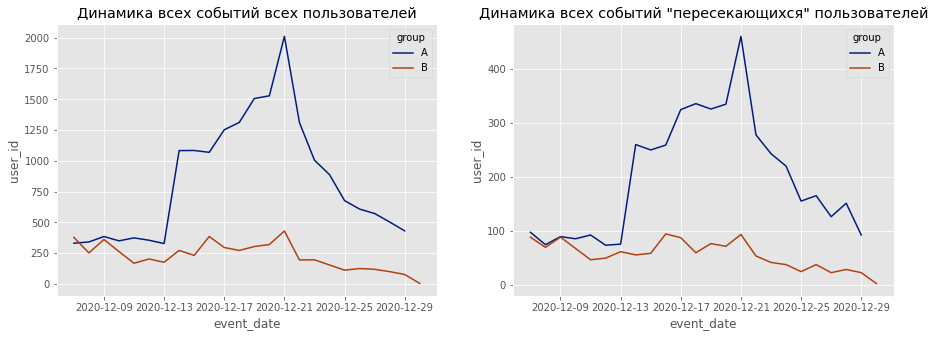

In [28]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=test.groupby(['event_date', 'group'])['user_id'].count().reset_index(),
            x='event_date', y='user_id', hue='group')
plt.title('Динамика всех событий всех пользователей')

plt.subplot(1,2,2)
sns.lineplot(data=test.query('user_id in @ab_intersect_users').groupby(['event_date', 'group'])['user_id'].count().reset_index(),
            x='event_date', y='user_id', hue='group')
plt.title('Динамика всех событий "пересекающихся" пользователей')
plt.show()

Может быть что-то не так с регистрациями пользователей на сайте, т.е. разгадка в атрибуте 'first_date' из набора users? 
Динамика также похожа

In [29]:
df1 = users.query('user_id in @ab_participants_users').groupby('first_date')['user_id'].nunique().reset_index()
df2 = users.query('user_id in @ab_intersect_users').groupby('first_date')['user_id'].nunique().reset_index()
df1 = df1.merge(df2, on='first_date', how='inner')

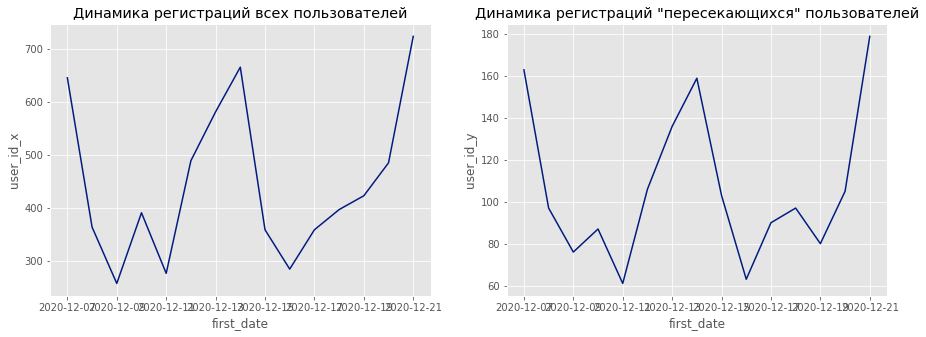

In [30]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=df1, x='first_date', y='user_id_x')
plt.title('Динамика регистраций всех пользователей')

plt.subplot(1,2,2)
sns.lineplot(data=df1, x='first_date', y='user_id_y')
plt.title('Динамика регистраций "пересекающихся" пользователей')
plt.show()



![shaurma](https://pbs.twimg.com/media/BExZH93CAAAhxdu.jpg)

### Маркетинговые активности

Проверим, какие маркетинговые кампании проводились во время теста. Напомним наши ключевые даты: 

1) Дата запуска тестирования: **2020-12-07**; 

2) Дата остановки набора новых пользователей: **2020-12-21**; 

3) Дата остановки: **2021-01-04**

В период с 7 декабря до момента окончания набора пользователей, маркетинговых кампаний не проводилось. 25 и 30 декабря уже после набора новых пользователей в тест проводились 2 рождественские кампании, одна для региона ЕС и Северной Америки, другая для стран СНГ (CIS).

Теоретически данные кампании могли повлиять на поведение пользователей и непосредственно склонить их совершить покупку именно из-за получения промо-кодов и сертификатов, а не из-за рекомендаций.

Целесообразно исследовать отдельно данный и провести тест для разных выборок - сравнивать события в целом до конца тестирования и отдельно сравнить события не позже 25 декабря для пользователей из я ЕС и Северной Америки и не позже 30 декабря для пользователей из СНГ.

Т.е. необходимо будет удалить часть событий для отдельных пользователей - данные события не войдут в воронку продаж (?? *не владею маркетинговым сленгом*)

С другой стороны, мы никак не можем оценить влияние прошедших до старта теста кампаний на поведение пользователя. В конце ноября проводилась акция, связанная с "черной пятницей", про привлечение пользователей мы также ничего не знаем, допустим баннер на стороннем сайте, промокод в журнале, смс рассылка. Пользователь мог прийти на сайт в момент теста по старой ссылке, смс, но зарегистрироваться и совершать покупки, думая, что всё еше "черная пятница" или просто так. Т.е. каналом привлечения была старая кампания, но пользователь не "расстроился" и попал в тест, и, возможно, у него даже сработал какой-нибудь промо-код, всякое бывает. 

In [31]:
# кампании, которые завершились до момента набора пользователей в тест - отсутствуют
calendar.query('finish_dt >= "2020-12-07" & finish_dt <= "2020-12-21"') 

,name,regions,start_dt,finish_dt


In [32]:
# кампании, которые начались после набора пользователей, но до окончания теста
calendar.query('start_dt >= "2020-12-07"') 

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [33]:
calendar.query('(start_dt >= "2020-12-07" & start_dt <= "2021-01-04") | (finish_dt >= "2020-12-07" & finish_dt <= "2021-01-04") | (start_dt <= "2020-12-07" & finish_dt >="2021-01-04") & ("EU" in regions)')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


### Регионы, устройства пользователей

Изучим информацию только о тех пользователях, которые являются участниками анализируемого теста. Для нагляности построем круговые диаграммы

**1) Регионы**

In [34]:
region = users.query('user_id in @ab_participants_users').groupby('region')['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)
region['ratio'] = region['user_id'] / region['user_id'].sum()
region

,region,user_id,ratio
2,EU,6351,0.95
3,N.America,223,0.03
0,APAC,72,0.01
1,CIS,55,0.01


<function matplotlib.pyplot.show(close=None, block=None)>

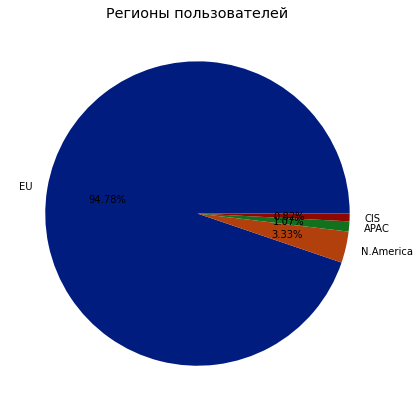

In [35]:
pie_label = region['region'].tolist()
plt.figure(figsize=(7,7))
plt.title('Регионы пользователей')
plt.pie(region['ratio'], labels=pie_label, autopct='%.2f%%')
plt.show

In [36]:
# сохраним инфрмацию о нужных пользователях в отдельный датафрейм
ab_users = users.query('user_id in @ab_participants_users')

In [37]:
print('Дата первых регистраций:', ab_users['first_date'].min())
print('Дата последних регистраци:', ab_users['first_date'].max())

Дата первых регистраций: 2020-12-07 00:00:00
Дата последних регистраци: 2020-12-21 00:00:00


В целом все пользователи, отобранные в предыдущем пункте - участники тестирования рекомендательной системы - зарегистрировались в системе в нужный период проведения теста с 7-го по 21 декабря 2020 г.

Условия ТЗ на количество пользователей из ЕС не менее 15 % соблюдено. 95% пользователей теста из ЕС.
Однако, в ТЗ нет уточнения: *"Аудитория: 15% новых пользователей из региона EU"*. Т.е.:

- среди участников теста (это все новые пользователи) должно быть не менее 15% пользователей из ЕС? **Выполнено**
- или среди вообще всех новых пользователей из набора данных с новыми пользователями доля пользователей из ЕС должна быть не менее 15%? Необходимо проверить.

Всего доля пользователей из ЕС из датафрейма users (все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года) составляет **74,9%**. Т.о. условие ТЗ также выполнено

In [38]:
6351 / 42430

0.14968182889465

In [39]:
ab_users.query('region == "EU"').groupby('region')['user_id'].nunique().reset_index()['user_id'].sum()/ \
users.query('first_date >= "2020-12-07" & first_date <= "2020-12-21" & region == "EU"').\
      groupby('region')['user_id'].nunique().reset_index()['user_id'].sum()

0.15

In [40]:
users.query('first_date >= "2020-12-07" & first_date <= "2020-12-21"').groupby('region')['user_id'].nunique().reset_index()

,region,user_id
0,APAC,2883
1,CIS,2900
2,EU,42340
3,N.America,8347


<function matplotlib.pyplot.show(close=None, block=None)>

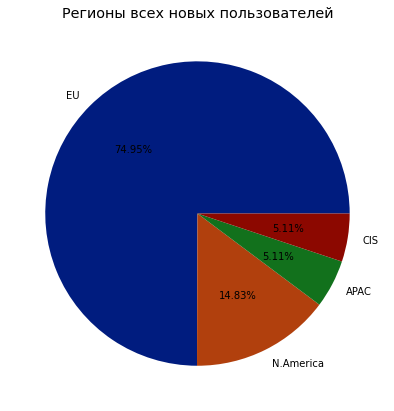

In [41]:
pie_label = region['region'].tolist()
plt.figure(figsize=(7,7))
plt.title('Регионы всех новых пользователей')
plt.pie(users.groupby('region')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)['user_id'],
        labels=pie_label, autopct='%.2f%%')
plt.show

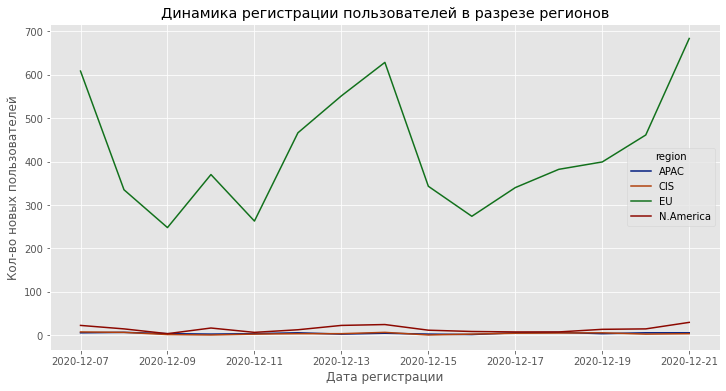

In [42]:
plt.figure(figsize=(12,6))
sns.lineplot(data=ab_users.groupby(['first_date', 'region'])['user_id'].count().reset_index(), 
             x='first_date', y='user_id', hue='region')
plt.title('Динамика регистрации пользователей в разрезе регионов')
plt.xlabel('Дата регистрации')
plt.ylabel('Кол-во новых пользователей')
plt.show()

Из динамики регистраций пользователей видно, что пики регистраций приходятся на субботу-понедельник, а во вторник-четверг наблюдается минимум регистраций

**2) Устройства**

In [43]:
devices = users.query('user_id in @ab_participants_users').groupby('device')['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)
devices['ratio'] = devices['user_id'] / devices['user_id'].sum()
devices

,device,user_id,ratio
0,Android,2983,0.45
2,PC,1707,0.25
3,iPhone,1378,0.21
1,Mac,633,0.09


/tmp/ipykernel_214/586748608.py:4: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie(devices['ratio'], labels=pie_label, autopct='%.0f%%')


<function matplotlib.pyplot.show(close=None, block=None)>

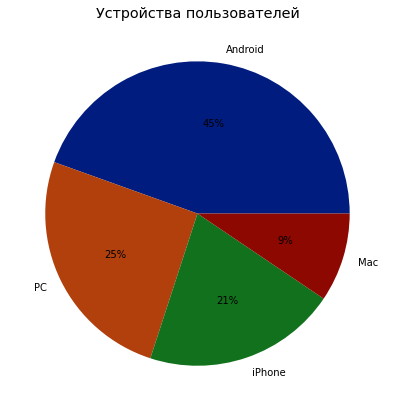

In [44]:
pie_label = devices['device'].tolist()
plt.figure(figsize=(7,7))
plt.title('Устройства пользователей')
plt.pie(devices['ratio'], labels=pie_label, autopct='%.0f%%')
plt.show

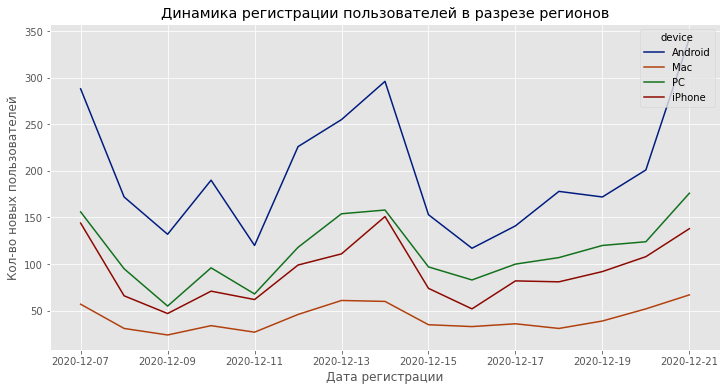

In [45]:
plt.figure(figsize=(12,6))
sns.lineplot(data=ab_users.groupby(['first_date', 'device'])['user_id'].count().reset_index(), 
             x='first_date', y='user_id', hue='device')
plt.title('Динамика регистрации пользователей в разрезе регионов')
plt.xlabel('Дата регистрации')
plt.ylabel('Кол-во новых пользователей')
plt.show()

Дополнительно проверили, что самыми популярными устройствами пользователей являются ПК и устройства на Android

### События

Объединим различную информацию о события, пользователях-участниках теста

In [46]:
# события участников теста
ab_events = events.query('user_id in @ab_participants_users')
# преобразуем данные о дате-времени просто в дату, удалим столбец со временем
ab_events['event_date'] = pd.to_datetime(ab_events['event_dt']).dt.date
ab_events = ab_events.drop(['event_dt'], axis=1)

/tmp/ipykernel_214/391391066.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab_events['event_date'] = pd.to_datetime(ab_events['event_dt']).dt.date


In [47]:
# обединим датафрейм с событиями и датафрейм с информацией о группе теста пользователя
ab_events_gen = ab_participants.merge(ab_events, on='user_id', how='left').drop(['ab_test'], axis=1)


In [48]:
# объединим датафремй с событиями с датафреймом с общей информацией о пользователях
ab_events_gen = ab_events_gen.merge(ab_users, on='user_id', how='inner')

In [49]:
ab_events_gen.query('user_id in @ab_intersect_users').pivot_table(index='event_name', columns='group', values='user_id', aggfunc='count')

group,A,B
event_name,,
login,2041,648
product_cart,569,156
product_page,1275,357
purchase,682,166


Рассмотрим динамику событий в некоторых разрезах

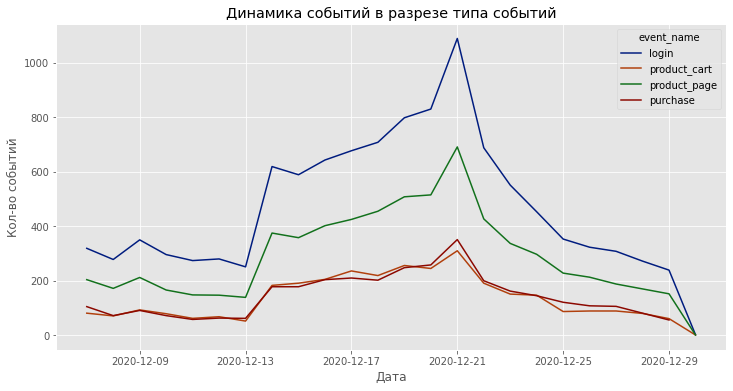

In [50]:
plt.figure(figsize=(12,6))
sns.lineplot(data=ab_events_gen.groupby(['event_date', 'event_name'])['user_id'].count().reset_index(), 
             x='event_date', y='user_id', hue='event_name')
plt.title('Динамика событий в разрезе типа событий')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.show()

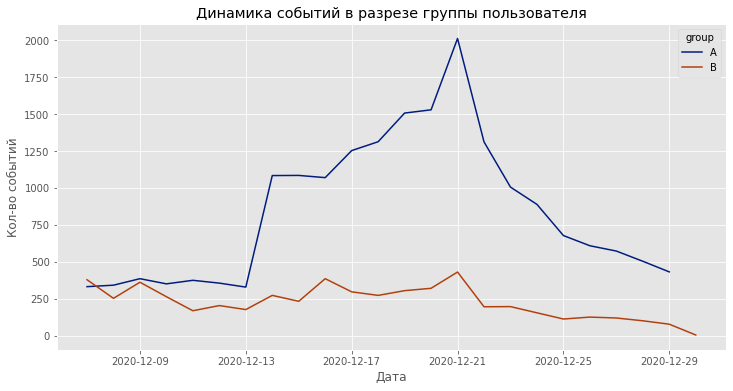

In [51]:
plt.figure(figsize=(12,6))
sns.lineplot(data=ab_events_gen.groupby(['event_date', 'group'])['user_id'].count().reset_index(), 
             x='event_date', y='user_id', hue='group')
plt.title('Динамика событий в разрезе группы пользователя')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.show()

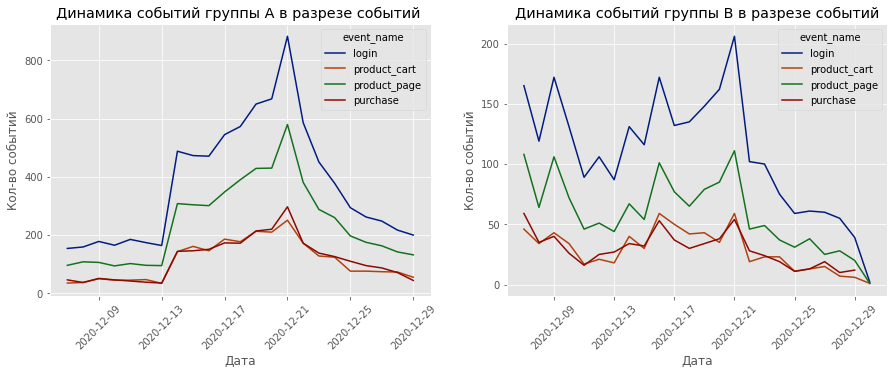

In [52]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.lineplot(data=ab_events_gen.query('group == "A"').groupby(['event_date', 'event_name'])['user_id'].count().reset_index(), 
             x='event_date', y='user_id', hue='event_name')
plt.title('Динамика событий группы А в разрезе событий ')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.lineplot(data=ab_events_gen.query('group == "B"').groupby(['event_date', 'event_name'])['user_id'].count().reset_index(), 
             x='event_date', y='user_id', hue='event_name')
plt.title('Динамика событий группы В в разрезе событий')
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.xticks(rotation=45)
plt.show()

Ка видно из представленных графиков с динамикой в первую неделю теста отсутсует какая-либо динамика в просмотрах товаров, их заказов, но после 13 декабря происходит резкий рост кол-ва всех событий, длящийся 8 дней (до 21 декабря). После наблюдается спад кол-ва событий. 

В основном такая динамика кол-ва событий характерна для пользоателей группы А. В группе В наблюдается случайная динамика событий в период с 7 по 21 декабря, а потом их уменьшение до 0 (как и в группе А)

#### Cобытия на одного пользователя в группах

Рассмотрим расперделение кол-ва событий на пользователя в разрезе типов событий по группам пользователей

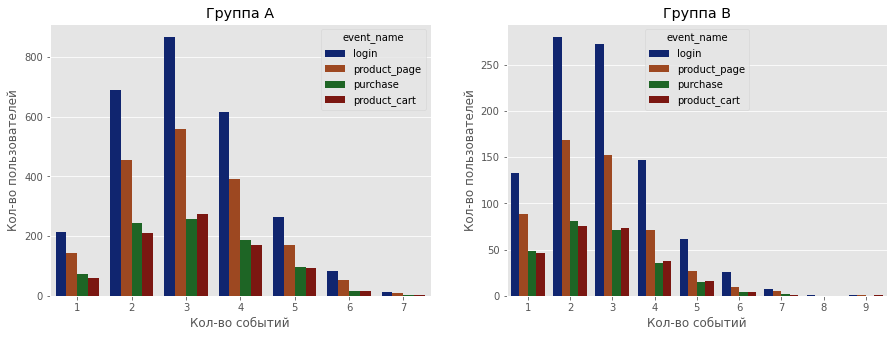

In [53]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Группа А')
sns.countplot(data=ab_events_gen.query('event_name !="reg" & group == "A"').groupby(['user_id','event_name'])['event_date'].count().reset_index(),
             x='event_date', hue='event_name')
plt.xlabel('Кол-во событий')
plt.ylabel('Кол-во пользователей')

plt.subplot(1,2,2)
plt.title('Группа В')
sns.countplot(data=ab_events_gen.query('event_name !="reg" & group == "B"').groupby(['user_id', 'event_name'])['event_date'].count().reset_index(),
             x='event_date', hue='event_name')
plt.xlabel('Кол-во событий')
plt.ylabel('Кол-во пользователей')

plt.show()

И распеределение кол-ва всех событий в разрезе групп пользователей

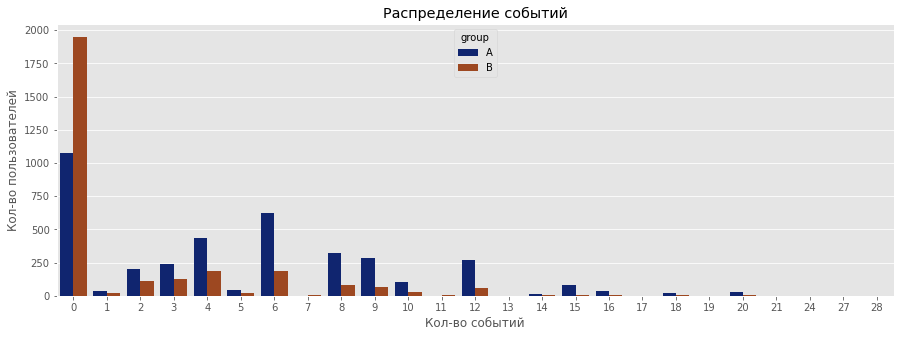

In [54]:
plt.figure(figsize=(15,5))
sns.countplot(data= ab_events_gen.query('event_name !="reg"'). \
              pivot_table(index=['user_id', 'group'], values='event_name', 
                          aggfunc='count').reset_index(), x='event_name', hue='group')
plt.title('Распределение событий')
plt.xlabel('Кол-во событий')
plt.ylabel('Кол-во пользователей')
plt.show()

In [55]:
#среднее кол-во событий на 1 пользователя в группе А
ab_events_gen.query('event_name !="reg" & group == "A"').\
                   groupby(['user_id','event_name'])['event_date'].count().reset_index().\
                   groupby('event_name')['event_date'].mean().reset_index()

,event_name,event_date
0,login,3.12
1,product_cart,3.10
2,product_page,3.10
3,purchase,3.04


In [56]:
# Среднее кол-во событий на 1 пользователя в группе В
ab_events_gen.query('event_name !="reg" & group == "B"').\
                   groupby(['user_id','event_name'])['event_date'].count().reset_index().\
                   groupby('event_name')['event_date'].mean().reset_index()

,event_name,event_date
0,login,2.83
1,product_cart,2.70
2,product_page,2.69
3,purchase,2.64


Пользователи группы А совершают больше действий, но в целом на одного пользователя приходится примерно 10-12 событий.

В среднем 1 пользователь в группе А совершает от 3-х действий каждого типа, пользователь в группе В - до 3-х

### Конверсии по дням

1) Добавим столбец с кол-вом дней с момента регистрации пользователя до момента события.

Т.к. уже производиись манипуляции с датой, придется опять "принудительно" преобразовывать типы. Также не стоит забывать, что в датафреме хранятся записи о регистрациях пользователей, которые не совершали больше никаких действий. 

In [57]:
ab_events_gen['lifetime'] =  pd.to_datetime(ab_events_gen['event_date'], 
                                            errors='coerce').dt.to_period('D').astype(int) \
                             - pd.to_datetime(ab_events_gen['first_date'], errors='coerce').dt.to_period('D').astype(int) + 1

2) Для расчета конверсии не будем учитывать пользователей, которые входят в группы теста, зарегистрировались, но не совершали никаких действий. Также, стоит отметить, что у пользователей, которые зарегистрировались 21 декабря "лайфтайм" составляет 9 дней. Т.е. часть пользователей не доживает до горизонта анализа.

- сначала сформируем таблицу, где будет посчитано суммарное кол-во событий для пользователей в разрезе их первого дня регистрации, лайфтайма и группы
- после сформируем "треугольную матрицу", для каждой когорты и каждого типа события с кол-вом таких событий для расчета конверсии каждой когорты
- сформируем таблицу с размерами когорт и объединим данные

In [58]:
def cr(df, event='', group='', ):
    
    #шаг 1. Создание таблицы с расчетом сумм кол-в событий
    result_df = df.query('event_name !="reg"').pivot_table(index=['first_date','lifetime', 'group'], 
                                                           columns='event_name', values='user_id', aggfunc='count').reset_index()
    
    #шаг 2 . Создание "треугольной матрицы"
    result_df = result_df.pivot_table(index=['first_date', 'group'], 
                                            columns='lifetime', values=event, 
                                            aggfunc='sum').reset_index()
    #шаг 3. Расчет размеров когорт
    cohorts = df.groupby(['first_date', 'group'])['user_id'].nunique().reset_index().rename(columns={'user_id':'cohort_size'})
    
    #шаг 4. Объединение таблиц, преобразование столбцов
    result_df = pd.concat([result_df, cohorts], axis=1)
    
    #шаг 5. Расчет конверсий
    #удаление лиших столбцов перед делением
    result_df=result_df.drop(['first_date','group'], axis=1)
    #разделение каждой ячейки на размер когорты
    result_df = result_df.div(result_df['cohort_size'], axis=0)
    
    #шаг 6. Постобработка
    #добавление инфрмации о размере когорт и группе
    result_df = pd.concat([result_df, cohorts], axis=1)
    #фильтрация по группе
    result_df = result_df.query('group == @group')
    #удаление столбца
    result_df = result_df.drop(['group', 'cohort_size'], axis=1)
    
    # Перестановка столбца
    columns = list(result_df.columns) 
    last_column = columns[-1]      #имя последнего столбца
    columns = [last_column] + columns[:-1]  # Переставляем последний столбец в начало списка

    # шаг 7. Переупорядоченный датафрей
    result_df = result_df[columns].reset_index().drop(['index'], axis=1)
    
    return result_df
    

In [59]:
ab_events_purchase_a = cr(ab_events_gen, event='purchase', group='A')

In [60]:
ab_events_purchase_a.style.background_gradient(cmap='Reds', axis=1)

,first_date,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,2020-12-07 00:00:00,0.125341,0.035422,0.040872,0.019074,0.016349,0.016349,0.019074,0.021798,0.016349,0.013624,0.008174,0.010899,0.005450,0.002725,0.002725,0.005450,0.002725,0.005450,0.010899,0.005450,0.010899,0.002725,0.002725,nan
1,2020-12-08 00:00:00,0.117073,0.068293,0.029268,0.024390,0.009756,0.024390,0.014634,0.009756,0.004878,0.009756,0.000000,0.014634,0.004878,0.004878,0.009756,0.000000,0.014634,0.014634,0.000000,0.000000,0.004878,0.000000,nan,nan
2,2020-12-09 00:00:00,0.149660,0.081633,0.034014,0.061224,0.020408,0.000000,0.006803,0.013605,0.013605,0.006803,0.013605,0.020408,0.013605,0.006803,0.000000,0.000000,0.013605,0.000000,0.000000,0.000000,0.006803,nan,nan,nan
3,2020-12-10 00:00:00,0.105528,0.055276,0.005025,0.015075,0.010050,0.005025,0.010050,0.015075,0.005025,0.000000,0.010050,0.000000,0.000000,0.005025,0.005025,0.010050,0.005025,0.000000,0.005025,0.000000,nan,nan,nan,nan
4,2020-12-11 00:00:00,0.090909,0.036364,0.024242,0.024242,0.006061,0.006061,0.012121,0.000000,0.000000,0.006061,0.012121,0.006061,0.000000,0.006061,0.000000,0.012121,0.012121,0.006061,0.006061,nan,nan,nan,nan,nan
5,2020-12-12 00:00:00,0.050725,0.018116,0.007246,0.007246,0.000000,0.000000,0.003623,0.000000,0.000000,0.007246,0.000000,0.003623,0.000000,0.000000,0.000000,nan,0.000000,0.000000,nan,nan,nan,nan,nan,nan
6,2020-12-13 00:00:00,0.023599,0.005900,0.002950,0.002950,0.002950,0.000000,0.000000,0.008850,0.000000,0.000000,0.000000,0.002950,0.000000,0.000000,0.000000,0.002950,0.000000,nan,nan,nan,nan,nan,nan,nan
7,2020-12-14 00:00:00,0.317829,0.149871,0.124031,0.087855,0.069767,0.069767,0.041344,0.049096,0.028424,0.036176,0.028424,0.025840,0.038760,0.028424,0.023256,0.010336,nan,nan,nan,nan,nan,nan,nan,nan
8,2020-12-15 00:00:00,0.355769,0.134615,0.120192,0.076923,0.091346,0.043269,0.038462,0.028846,0.028846,0.028846,0.062500,0.024038,0.033654,0.019231,0.009615,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,2020-12-16 00:00:00,0.372781,0.159763,0.130178,0.076923,0.059172,0.076923,0.065089,0.047337,0.053254,0.023669,0.029586,0.005917,0.023669,0.011834,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [61]:
ab_events_purchase_b = cr(ab_events_gen, event='purchase', group='B')

In [62]:
ab_events_purchase_b.style.background_gradient(cmap='Reds', axis=1)

,first_date,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,2020-12-07 00:00:00,0.212230,0.082734,0.064748,0.039568,0.032374,0.025180,0.035971,0.025180,0.021583,0.017986,0.010791,0.014388,0.021583,0.007194,0.010791,0.003597,0.014388,0.014388,0.007194,0.014388,0.014388,0.010791,0.014388,0.000000
1,2020-12-08 00:00:00,0.075472,0.031447,0.012579,0.018868,0.000000,0.006289,0.012579,0.000000,0.006289,0.000000,0.006289,0.006289,0.012579,0.000000,nan,0.000000,0.000000,0.006289,0.000000,nan,0.000000,0.000000,nan,nan
2,2020-12-09 00:00:00,0.153153,0.045045,0.009009,0.027027,0.045045,0.009009,0.036036,0.036036,0.027027,0.009009,0.000000,0.018018,0.009009,0.009009,0.009009,0.009009,0.000000,0.018018,0.009009,0.009009,0.000000,nan,nan,nan
3,2020-12-10 00:00:00,0.041667,0.005208,0.015625,0.005208,0.005208,0.000000,0.005208,0.005208,0.000000,0.005208,0.000000,0.000000,0.000000,nan,0.000000,0.000000,nan,0.000000,0.000000,0.000000,nan,nan,nan,nan
4,2020-12-11 00:00:00,0.017857,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000,nan,nan,0.000000,nan,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,nan,nan,nan,nan,nan
5,2020-12-12 00:00:00,0.056338,0.028169,0.023474,0.009390,0.009390,0.004695,0.000000,0.000000,0.000000,0.004695,0.000000,0.000000,0.000000,0.004695,0.000000,0.014085,0.000000,0.004695,nan,nan,nan,nan,nan,nan
6,2020-12-13 00:00:00,0.016529,nan,0.004132,0.000000,0.000000,nan,0.000000,nan,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan
7,2020-12-14 00:00:00,0.064748,0.032374,0.010791,0.010791,0.003597,0.007194,0.000000,0.000000,0.014388,0.003597,0.000000,0.000000,0.003597,0.000000,0.003597,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,2020-12-15 00:00:00,0.066225,0.026490,0.019868,0.000000,0.013245,0.000000,0.013245,0.013245,0.000000,0.000000,0.000000,0.000000,nan,0.006623,0.006623,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,2020-12-16 00:00:00,0.284483,0.103448,0.077586,0.043103,0.051724,0.051724,0.025862,0.051724,0.025862,0.017241,0.017241,0.025862,0.017241,0.017241,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Т.о. получили значения конверсий для всех пользователей из разных групп в зависимости от даты их первой регистрации (когорты) и дня лайфтайма.

Рассмотрим в графическом виде (дополнительно преобразуем таблицы)

In [63]:
cr_a_mean= ab_events_purchase_a.melt(id_vars=['first_date'], var_name='days', value_name='cr')['cr'].mean()
cr_b_mean= ab_events_purchase_b.melt(id_vars=['first_date'], var_name='days', value_name='cr')['cr'].mean()

cr_a_median= ab_events_purchase_a.melt(id_vars=['first_date'], var_name='days', value_name='cr')['cr'].median()
cr_b_median= ab_events_purchase_b.melt(id_vars=['first_date'], var_name='days', value_name='cr')['cr'].median()


print('Средняя конверсия в группе А: {:.2%}'.format(cr_a_mean))
print('Средняя конверсия в группе A: {:.2%}'.format(cr_a_median))
print('Мединанная конверсия в группе B: {:.2%}'.format(cr_a_mean))
print('Медианная конверсия в группе B: {:.2%}'.format(cr_b_median))


Средняя конверсия в группе А: 4.33%
Средняя конверсия в группе A: 1.82%
Мединанная конверсия в группе B: 4.33%
Медианная конверсия в группе B: 0.66%


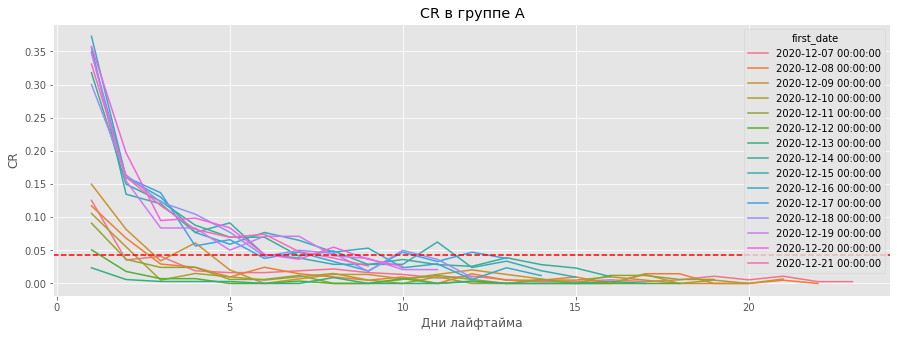

In [64]:
plt.figure(figsize=(15,5))
sns.lineplot(data=ab_events_purchase_a.melt(id_vars=['first_date'],
                                            var_name='days', value_name='cr'), 
             x='days', y='cr', hue='first_date')
plt.title('CR в группе А')
plt.xlabel('Дни лайфтайма')
plt.ylabel('CR')

plt.axhline(y=0.0433, color='red', linestyle='--')

plt.show()

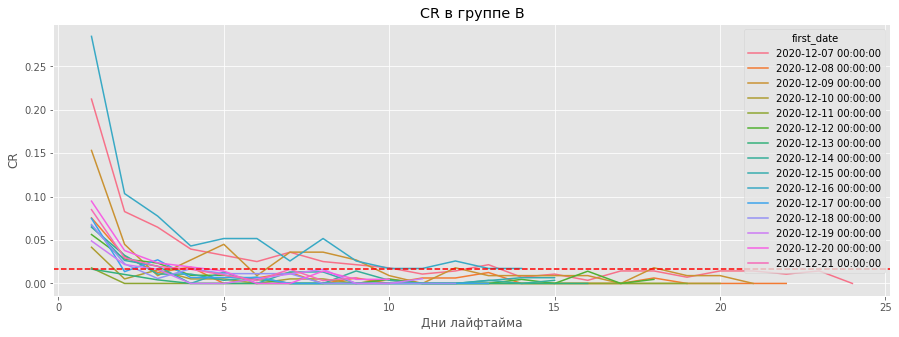

In [65]:
plt.figure(figsize=(15,5))
sns.lineplot(data=ab_events_purchase_b.melt(id_vars=['first_date'],
                                            var_name='days', value_name='cr'), 
             x='days', y='cr', hue='first_date')
plt.title('CR в группе B')
plt.xlabel('Дни лайфтайма')
plt.ylabel('CR')

plt.axhline(y=0.0161, color='red', linestyle='--')

plt.show()

In [66]:
cr_14_a = ab_events_purchase_a.melt(id_vars=['first_date'], var_name='days', value_name='cr')
cr_14_b = ab_events_purchase_b.melt(id_vars=['first_date'], var_name='days', value_name='cr')
cr_14_a['days'] = cr_14_a['days'].astype('int')
cr_14_b['days'] = cr_14_b['days'].astype('int')

In [67]:
print('Конверсия за 14 дней в группе А:{:.2%}'.format(cr_14_a.query('days <= 14')['cr'].mean()))
print('Конверсия за 14 дней в группе B:{:.2%}'.format(cr_14_b.query('days <= 14')['cr'].mean()))
print('Конверсия на 14-й день в группе А:{:.2%}'.format(cr_14_a.query('days == 14')['cr'].mean()))
print('Конверсия на 14-й день в группе B:{:.2%}'.format(cr_14_b.query('days == 14')['cr'].mean()))

Конверсия за 14 дней в группе А:5.19%
Конверсия за 14 дней в группе B:1.87%
Конверсия на 14-й день в группе А:0.85%
Конверсия на 14-й день в группе B:0.56%


Т.о. в контрольной группе конверсия лучше, чем в группе пользователей, привлеченных из новой платежной воронки. Средняя конерсия в группе А - 4,3% (равна медианной) против 1,6% в группе В.

#### Средняя конверсия

Построим график средней конверсии

In [68]:
#рассчитаем среднее по массивам
mean_cr_a = ab_events_purchase_a.mean().reset_index().rename(columns={0:'A'})
mean_cr_b = ab_events_purchase_b.mean().reset_index().rename(columns={0:'B'})

/tmp/ipykernel_214/4251498327.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean_cr_a = ab_events_purchase_a.mean().reset_index().rename(columns={0:'A'})
/tmp/ipykernel_214/4251498327.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean_cr_b = ab_events_purchase_b.mean().reset_index().rename(columns={0:'B'})


In [69]:
#
mean_cr =pd.concat([mean_cr_a, mean_cr_b], axis=1)

In [70]:
#
mean_cr=mean_cr.drop(['index'], axis=1)

<Figure size 720x360 with 0 Axes>

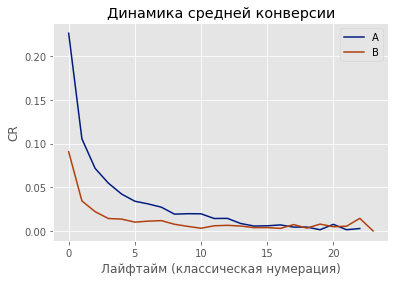

In [71]:
plt.figure(figsize=(10,5))
mean_cr.plot()
plt.title('Динамика средней конверсии')
plt.xlabel('Лайфтайм (классическая нумерация)')
plt.ylabel('CR')
plt.show()

### Воронка

#### Общий случай

 Наша продуктовая воронка:
 - регистрация/авторизация (login)
 - просмотр страницы продукции (product_page)
 - просмотрт/вход на карточку продукции/корзина (product_cart)
 - заказ (purchase)
 

 Обратим внимание, что объединенный датафрейм содержит пропуски в атрибуте event_name
 

In [72]:
ab_events_gen['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login', nan],
      dtype=object)

In [73]:
ab_events_gen.query('event_name.isna()')

,user_id,group,event_name,details,event_date,first_date,region,device,lifetime
32,482F14783456D21B,B,NaN,NaN,NaN,2020-12-14,EU,PC,9223372036854757199
59,057AB296296C7FC0,B,NaN,NaN,NaN,2020-12-17,EU,iPhone,9223372036854757196
66,E9FA12FAE3F5769C,B,NaN,NaN,NaN,2020-12-14,EU,Android,9223372036854757199
67,FDD0A1016549D707,A,NaN,NaN,NaN,2020-12-13,EU,PC,9223372036854757200
68,547E99A7BDB0FCE9,A,NaN,NaN,NaN,2020-12-12,EU,iPhone,9223372036854757201
...,...,...,...,...,...,...,...,...,...
27640,B5C6C830427BA3F3,A,NaN,NaN,NaN,2020-12-07,N.America,Android,9223372036854757206
27653,03F889B99919FBF1,A,NaN,NaN,NaN,2020-12-07,N.America,Android,9223372036854757206
27659,E10D3866C04D7949,B,NaN,NaN,NaN,2020-12-08,N.America,iPhone,9223372036854757205
27681,CD9752DE672640C1,A,NaN,NaN,NaN,2020-12-08,N.America,PC,9223372036854757205


Пропуски означают, что данные пользователи не совершали никаких действий, а просто зарегистрировались. Заменим пропуски в атрибуте на тип 'reg' = регистрация

In [74]:
ab_events_gen['event_name'] = ab_events_gen['event_name'].fillna('reg')

In [75]:
funnel_events = ab_events_gen.groupby('event_name')['user_id'].count().\
                reindex(['reg', 'login','product_page','product_cart','purchase']).reset_index()
funnel_events = funnel_events.rename(columns={'user_id':'count'})
funnel_users = ab_events_gen.groupby('event_name')['user_id'].nunique().\
               reindex(['reg', 'login','product_page','product_cart','purchase']).reset_index()
funnel_users = funnel_users.rename(columns={'user_id':'count'})

In [76]:
funnel_users

,event_name,count
0,reg,3026
1,login,3675
2,product_page,2303
3,product_cart,1079
4,purchase,1128


In [77]:
unique_users = ab_events_gen['user_id'].nunique()
unique_users_a = ab_events_gen.query('group == "A"')['user_id'].nunique()
unique_users_b = ab_events_gen.query('group == "B"')['user_id'].nunique()
unique_users

6701

Т.о. из 6701 уникального пользователя теста, 3675 пользователей совершали вход в систему, 2303 просматривали страницу продукта, 1079 просматривали карточку продукта и только 1128 совершили заказ. Т.е. 3026 пользователей не совершали никаких действий (~ 45%) и по большому счету в тесте не участвовали. Значит, **условие ТЗ о количестве пользователей в 6000 не соблюдено**

Стоит отметить, что некоторые пользователи совершали заказ без просмотра карточки товара.

Добавим информацию о кол-ве зарегистрированных пользователей и посчитаем конверсию

In [78]:
reg = {'event_name' : 'total_reg', 'count': unique_users}
funnel_users = funnel_users.append(reg, ignore_index=True)
#funnel_users = funnel_users.reindex(['reg','login','product_page','product_cart','purchase']).reset_index()
funnel_users['CR'] = (funnel_users['count'] / unique_users)
funnel_users

,event_name,count,CR
0,reg,3026,0.45
1,login,3675,0.55
2,product_page,2303,0.34
3,product_cart,1079,0.16
4,purchase,1128,0.17
5,total_reg,6701,1.00


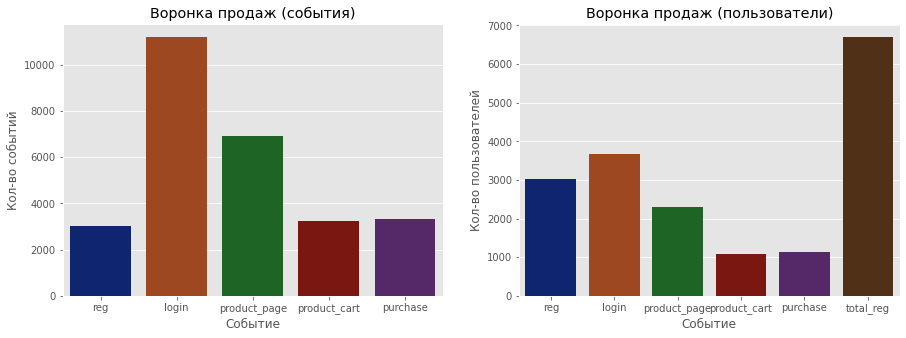

In [79]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data =funnel_events, x='event_name', y='count')
plt.title('Воронка продаж (события)')
plt.xlabel('Событие')
plt.ylabel('Кол-во событий')

plt.subplot(1,2,2)
sns.barplot(data =funnel_users, x='event_name', y='count')
plt.title('Воронка продаж (пользователи)')
plt.xlabel('Событие')
plt.ylabel('Кол-во пользователей')

plt.show()


Т.о. только 55% из 6701 пользователей осуществили вход в систему, 17% совершили покупку. Рассмотрим конверсию внутри групп теста.

In [80]:
funnel_details = ab_events_gen.pivot_table(index='event_name', columns='group', 
                                           values='user_id', aggfunc='nunique').reindex(['login','product_page','product_cart','purchase']).reset_index()

funnel_details['CR_A'] = funnel_details['A'] / unique_users_a
funnel_details['CR_B'] = funnel_details['B'] / unique_users_b
funnel_details['A/B'] = funnel_details['CR_A'] / funnel_details['CR_B']
funnel_details['B-A'] = funnel_details['CR_B'] - funnel_details['CR_A']
funnel_details

group,event_name,A,B,CR_A,CR_B,A/B,B-A
0,login,2747,928,0.72,0.32,2.23,-0.40
1,product_page,1780,523,0.47,0.18,2.56,-0.28
2,product_cart,824,255,0.22,0.09,2.43,-0.13
3,purchase,872,256,0.23,0.09,2.56,-0.14


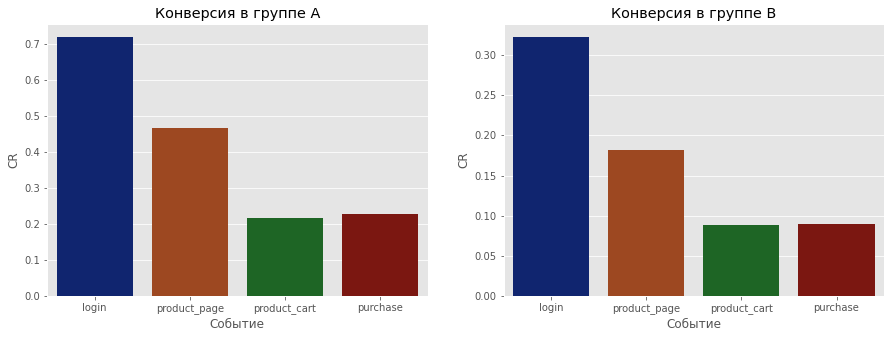

In [81]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data =funnel_details, x='event_name', y='CR_A')
plt.title('Конверсия в группе А')
plt.xlabel('Событие')
plt.ylabel('CR')

plt.subplot(1,2,2)
sns.barplot(data =funnel_details, x='event_name', y='CR_B')
plt.title('Конверсия в группе В')
plt.xlabel('Событие')
plt.ylabel('CR')

plt.show()

В целом по данным диаграммам видно, что в группе В конверсия хуже в 2,2-2,5 раза, чем в группе А.

Т.о. только 23% пользователей группы А и 9% группы В совершили покупку, в т.ч.:

- "конверсия логинов" ухудшилась на 40%
- "конверсия просмотра страниц" ухудшилась на 28%
- "конверсия просмотра карточек" ухудшилась на 13%
- "конверсия покупок" ухудшилась на 14% 

#### Воронка за 14 дней

**Для построения продуктовой воронки и ответа на главный вопрос про эффекты за 14 дней с момента регистрации в системе необходимо исключить все события, для которых "лайфтайм" более 14, а также тех пользователей, которые не дожили 14 дней до конца теста, т.е. тех, у кого "first_date" >= 2020-12-16**

Также в данной воронке будут отсутствовоать те пользователи, которые только зарегистрировались и не совершали никаких действий

In [82]:
ab_events_14 = ab_events_gen.query('lifetime <= 14')

In [83]:
ab_events_14 = ab_events_14.query('first_date <= "2020-12-16"')

In [84]:
unique_users_14 = ab_events_14['user_id'].nunique()
unique_users_a_14 = ab_events_14.query('group == "A"')['user_id'].nunique()
unique_users_b_14 = ab_events_14.query('group == "B"')['user_id'].nunique()


funnel_details_14 = ab_events_14.pivot_table(index='event_name', columns='group', 
                                           values='user_id', aggfunc='nunique').reindex(['login','product_page','product_cart','purchase']).reset_index()

funnel_details_14['CR_A'] = funnel_details_14['A'] / unique_users_a_14
funnel_details_14['CR_B'] = funnel_details_14['B'] / unique_users_b_14
funnel_details_14['A/B'] = funnel_details_14['CR_A'] / funnel_details_14['CR_B']
funnel_details_14['B-A'] = funnel_details_14['CR_B'] - funnel_details_14['CR_A']
funnel_details_14

group,event_name,A,B,CR_A,CR_B,A/B,B-A
0,login,1385,635,1.00,1.00,1.00,-0.00
1,product_page,875,364,0.63,0.57,1.10,-0.06
2,product_cart,408,177,0.29,0.28,1.06,-0.02
3,purchase,413,178,0.30,0.28,1.07,-0.02


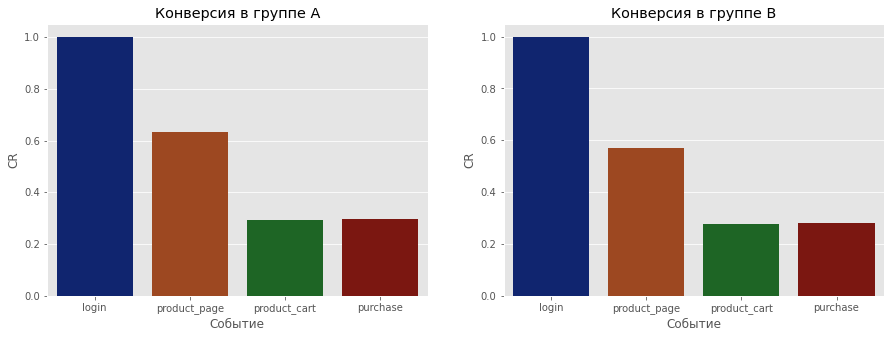

In [85]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data =funnel_details_14, x='event_name', y='CR_A')
plt.title('Конверсия в группе А')
plt.xlabel('Событие')
plt.ylabel('CR')

plt.subplot(1,2,2)
sns.barplot(data =funnel_details_14, x='event_name', y='CR_B')
plt.title('Конверсия в группе В')
plt.xlabel('Событие')
plt.ylabel('CR')

plt.show()

Если отбирать пользователей таким образом, то конверсия будет естественно лучше. 
Т.о. из всех пользователей (6701 пользователь оригинального теста), тех кто совершал какие-либо действия на сайте, кроме регистрации "первого дня", осталось 1385 в группе А и 635 в группе В.

Всего до этапа покупки дошло 30% из группы А и 28% из группы В.

Отметим также, что "конверсия" покупки в группе А выше, чем "конверсия" просмотра карточки продукта, т.е. на сайте, видимо, есть возможность/функционал по типу "купить в один клиК" без перехода на карточку продукта

### Средний чек

В рамках исследовательского анализа мы не проводили анализ расходов пользователей. Исправим ситуацию. Т.к. на данном этапе исследуются только "платившие пользователи", то сразу же отфильтруем необходимые данные

In [86]:
avg_bill = ab_events_gen.query('details !=0').dropna()

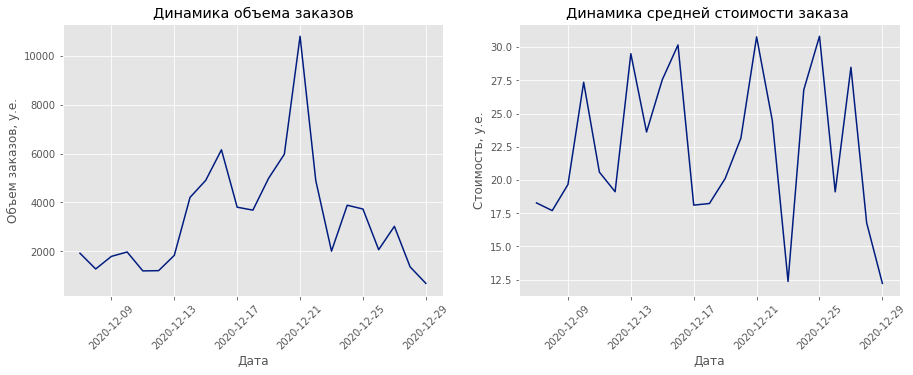

In [87]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.lineplot(data = avg_bill.groupby('event_date')['details'].sum().reset_index(), x='event_date', y='details')
plt.title('Динамика объема заказов')
plt.xlabel('Дата')
plt.ylabel('Объем заказов, у.е.')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.lineplot(data = avg_bill.groupby('event_date')['details'].mean().reset_index(), x='event_date', y='details')
plt.title('Динамика средней стоимости заказа ')
plt.xlabel('Дата')
plt.ylabel('Стоимость, у.е.')
plt.xticks(rotation=45)
plt.show()


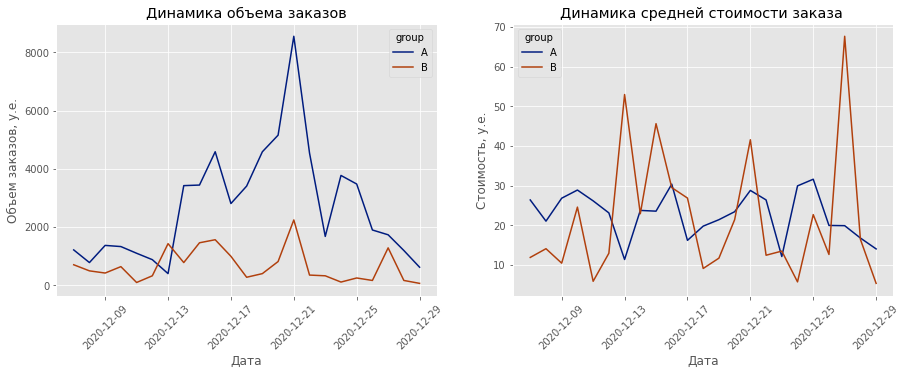

In [88]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.lineplot(data = avg_bill.groupby(['event_date', 'group'])['details'].sum().reset_index(), x='event_date', y='details', hue='group')
plt.title('Динамика объема заказов')
plt.xlabel('Дата')
plt.ylabel('Объем заказов, у.е.')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.lineplot(data =avg_bill.groupby(['event_date', 'group'])['details'].mean().reset_index(), x='event_date', y='details', hue='group')
plt.title('Динамика средней стоимости заказа ')
plt.xlabel('Дата')
plt.ylabel('Стоимость, у.е.')
plt.xticks(rotation=45)
plt.show()

Как видно из графиков профиль кривой динамики общих объемов заказов в некотором приближении соответствует профилю активности пользователей в целом: стабильное плато, рост, падение. И в основном такая динамика достигается за счет пользователей группы А, т.к. для пользователей группы В характерна более беспорядочная динамика. Средний размер заказа колеблется на протяжении всего периода наблюдений, но судя по графику средняя стоимость заказа (средние чеки) в разных группах примерно одинаковые, за счет более высоких значений у пользователей группы В.

Рассмотрим значение среднего чека в разрезе пользователей и в других разрезах

1) Средний чек пользователя

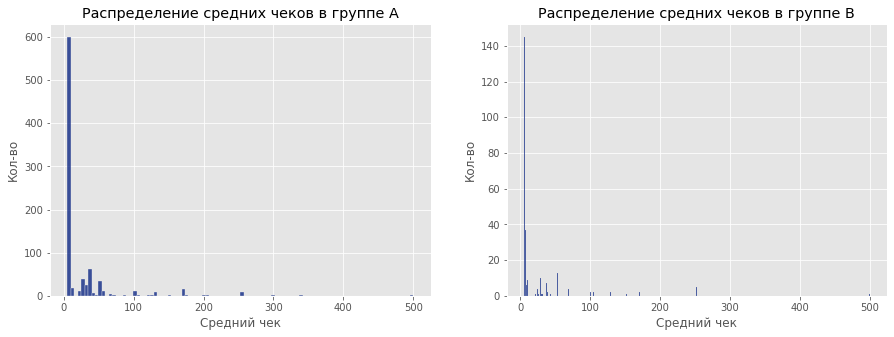

In [89]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.histplot(avg_bill.groupby(['group', 'user_id'])['details'].mean().reset_index().query('group =="A"'), x='details')
plt.title('Распределение средних чеков в группе А')
plt.xlabel('Средний чек')
plt.ylabel('Кол-во')


plt.subplot(1,2,2)
sns.histplot(avg_bill.groupby(['group', 'user_id'])['details'].mean().reset_index().query('group =="B"'), x='details')
plt.title('Распределение средних чеков в группе B')
plt.xlabel('Средний чек')
plt.ylabel('Кол-во')

plt.show()

In [90]:
print('Средний чек в группе А: {:.2f}'.format(avg_bill.groupby(['group', 'user_id'])['details'].mean().reset_index().query('group =="A"')['details'].mean()))
print('Средний чек в группе B: {:.2f}'.format(avg_bill.groupby(['group', 'user_id'])['details'].mean().reset_index().query('group =="B"')['details'].mean()))

Средний чек в группе А: 24.94
Средний чек в группе B: 22.94


Т.е. на самом деле средние чеки в группах различаютс не кардинально, но в группе В он меньше

2) Средний чек в зависимости от региона

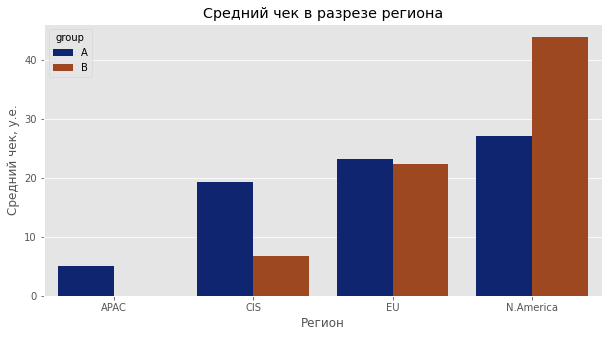

In [91]:
plt.figure(figsize=(10,5))
sns.barplot(data = avg_bill.groupby(['group','region'])['details'].mean().reset_index(), x='region', y='details', hue='group')
plt.title('Средний чек в разрезе региона')
plt.xlabel('Регион')
plt.ylabel('Средний чек, у.е.')
plt.show()

In [92]:
avg_bill.groupby(['group','region'])['details'].mean().reset_index()

,group,region,details
0,A,APAC,4.99
1,A,CIS,19.28
2,A,EU,23.21
3,A,N.America,27.10
4,B,CIS,6.66
5,B,EU,22.37
6,B,N.America,43.84


Величина среднего чека сильно зависит от региона. Т.к. наибольший средний чек характерен на пользователей из Северной Америки, в особенности из группы В - 44 у.е., в тоже время средний чек для пользователей группы А из того е региона - 27 у.е.

Наименьший средний чек выявлен у пользователей тихоокеанского региона в группе А и из СНГ в группе В - 5 и 6,6 у.е. соответственно.

У пользователей из ЕС средний чек в зависимости от групп примерно одинаковый - 22-23 у.е. Что вполне логично, т.к. 95% всех пользователей из ЕС. Именно они усредняют всю выборку.

В рамказ оценки результатов А/В теста также можно будет дополнительно сравнить средний чек

### Вывод по EDA

1) Всего пользователей в тесте 6701, в группе А 3834, в группе В 2877, что соответсвует требованию ТЗ в 6000 пользователей. Однако, ровно 1602 пользователя из "recommender_system_test" также входят в группу пользователей теста "inеrface_eu_test". В целом такая ситуация не является чем-то из ряда вох выходящим, поэтому "пересекающиеся пользователи сохранены для дальнейшего анализа.

2) В период с 7 декабря до момента окончания набора пользователей, маркетинговых кампаний не проводилось. 25 и 30 декабря уже после набора новых пользователей в тест проводились 2 рождественские кампании, одна для региона ЕС и Северной Америки, другая для стран СНГ (CIS). Теоретически данные кампании могли повлиять на поведение пользователей и непосредственно склонить их совершить покупку именно из-за получения промо-кодов и сертификатов, а не из-за рекомендаций. С другой стороны, нет возможности оценить влияние прошедших до старта теста кампаний на поведение пользователя.  Поэтому было решено принебречь возможным эффектом других кампаний

3) Условия ТЗ на количество пользователей из ЕС не менее 15 % соблюдено. 95% пользователей теста из ЕС. Однако, в ТЗ нет уточнения: *"Аудитория: 15% новых пользователей из региона EU"*. Т.е.:

- среди участников теста (это все новые пользователи) должно быть не менее 15% пользователей из ЕС? Выполнено
-  среди вообще всех новых пользователей из набора данных с новыми пользователями доля пользователей из ЕС должна быть не менее 15% 

Всего доля пользователей из ЕС из датафрейма users (все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года) составляет 74,9%. Т.о. условие ТЗ также выполнено

4) Самыми популярными устройствами пользователей являются ПК и устройства на Android

5) В первую неделю теста отсутсует какая-либо динамика в просмотрах товаров, их заказов, но после 13 декабря происходит резкий рост кол-ва всех событий, длящийся 8 дней (до 21 декабря). После наблюдается спад кол-ва событий. В основном такая динамика кол-ва событий характерна для пользоателей группы А. В группе В наблюдается случайная динамика событий в период с 7 по 21 декабря, а потом их уменьшение до 0 (как и в группе А).

6) Пользователи группы А совершают больше действий, но в целом на одного пользователя приходится примерно 10-12 событий. В среднем 1 пользователь в группе А совершает от 3-х действий каждого типа, пользователь в группе В - до 3-х.

7) Из 6701 уникального пользователя теста, 3675 пользователей совершали вход в систему, 2303 просматривали страницу продукта, 1079 просматривали карточку продукта и только 1128 совершили заказ. Т.е. 3026 пользователей не совершали никаких действий (~ 45%) и по большому счету в тесте не участвовали. Значит в итоге, условие ТЗ о количестве пользователей в 6000 не соблюдено.

8) В группе В конверсия хуже в 2,2-2,5 раза, чем в группе А. Только 23% пользователей группы А и 9% группы В совершили покупку, в т.ч.:

- "конверсия логинов" ухудшилась на 40%
- "конверсия просмотра страниц" ухудшилась на 28%
- "конверсия просмотра карточек" ухудшилась на 13%
- "конверсия покупок" ухудшилась на 14%

    **8.1) Если учесть только тех пользователей, которые участвовали в тесте с момента регистрации полные 14 дней, то таких пользователей окажется только 1385 в группе А и 635 в группе В. Изних всего до этапа покупки дойдет 30% из группы А и 28% из группы В. До просмотра страциц и просмотра карточек в группах А и В дойдет 63%,57% и 29%,28% соответственно.
    Т.е. значение метрик группы В меньше, чем группы А**

9) Если рассматривать конверсию по когортам, сформированых в зависимости от первого дня регистрации пользователя, то выявлено следующее:

- Средняя конверсия в группе А: 4.33%
- Средняя конверсия в группе A: 1.82%

На 14 день значения конверсий для групп А и В состалвяют 5,19% и 1,87% соответственно, при этом непосредственно в 14-й день конверсия равна 0,85% и 0,56%.

**Т.о. за 14 дней с момента регистрации в системе пользователи не показали улучшение каждой метрики не менее, чем на 10%**

10) Профиль кривой динамики общих объемов заказов в некотором приближении соответствует профилю активности пользователей в целом: стабильное плато, рост, падение. И в основном такая динамика достигается за счет пользователей группы А, т.к. для пользователей группы В характерна более беспорядочная динамика. Средний размер заказа колеблется на протяжении всего периода наблюдений, но судя по графику средняя стоимость заказа (средние чеки) в разных группах примерно одинаковые, за счет более высоких значений у пользователей группы В:

Величина среднего чека сильно зависит от региона. Т.к. наибольший средний чек характерен на пользователей из Северной Америки, в особенности из группы В - 44 у.е., в тоже время средний чек для пользователей группы А из того е региона - 27 у.е.Наименьший средний чек выявлен у пользователей тихоокеанского региона в группе А и из СНГ в группе В - 5 и 6,6 у.е. соответственно. У пользователей из ЕС средний чек в зависимости от групп примерно одинаковый - 22-23 у.е. Что вполне логично, т.к. 95% всех пользователей из ЕС. Именно они усредняют всю выборку.

- Средний чек в группе А: 24.94
- Средний чек в группе B: 22.94

Можно также утверждать, что в целом, данные на которых проводится тест, не в полной мере удовлетворяет требованиям ТЗ, т.к. не было набрано достаточного кол-ва пользователей, не все пользователи "успели прожить" необходмое кол-во дней до момента остановки теста, данных для анализа таких пользователей не предоставили в полном объеме.



## Оценка результатов тестирования

### Проверка равенства долей

В предыдущем разделе мы построили 2 воронки:

1) Общая для всех пользователей, которые зарегистрировались в тест

2) Частная для пользователей, которые прожили до конца теста с момента регистрации 14 дней и зарегистрировались до дня Х, в которой не учитываются события после 14 дня лайфтайма.

Проведем тетсирования для обеих групп пользователей

Результаты тестирования будем проверять с помощью z-теста для проверки равенства долей

Сформулируем гипотезы: 

- Н0: между долями пользователей в группах А и В от общего числа пользователей в группах совершивших какое-либо действие нет статистически значимой разницы, т.е. доли одинаковые
- Н1: разница между долями пользователей в группах А и В от общего числа пользователей в группах совершивших какое-либо действие статистически значима, т.е. доли разные



1) Подготовим данные для z-теста

1.1) По всей выборке

In [93]:
# сформируем таблицу из уже готовой таблицы с данными для воронки
data=funnel_details[['event_name', 'A', 'B']]
# добавим новую строку со значением кол-ва пользователей в каждой группе
reg = {'event_name' : 'total_reg', 'A': unique_users_a, 'B': unique_users_b }
data = data.append(reg, ignore_index=True)
#транспонируем таблицу и зададим новую строку заголвоков
data = data.T
data.columns = data.iloc[0]
data = data[1:]
# преобразуем в число
data = data.astype(int)


In [94]:
data

event_name,login,product_page,product_cart,purchase,total_reg
A,2747,1780,824,872,3824
B,928,523,255,256,2877


1.2) Для пользователей из воронки 14 дней 

In [95]:
# сформируем таблицу из уже готовой таблицы с данными для воронки
data_14=funnel_details_14[['event_name', 'A', 'B']]
# добавим новую строку со значением кол-ва пользователей в каждой группе
reg = {'event_name' : 'total_reg', 'A': unique_users_a, 'B': unique_users_b }
data_14 = data_14.append(reg, ignore_index=True)
#транспонируем таблицу и зададим новую строку заголвоков
data_14 = data_14.T
data_14.columns = data_14.iloc[0]
data_14 = data_14[1:]
# преобразуем в число
data_14 = data_14.astype(int)

In [96]:
data_14

event_name,login,product_page,product_cart,purchase,total_reg
A,1385,875,408,413,3824
B,635,364,177,178,2877


Зададим альфа. т.к. проверяется несколько гипотез одновременно, то будем это учитывать с помощью метода Бонферрони.

Поэтому для первого теста по выборке из всех пользователей примем поправку равную 4, т.к. в тесте будет 4 проверки, а для второго теста -3, т.к. этап с входом в систему будет пропущен - все пользователи из воронки совершили вход в систему.

In [97]:
α = 0.05
α1 = 0.05/4
α2 = 0.05/3

2) Создадим функции для расчета p-value для z-теста

In [98]:
def z_test(α, data):
    '''
    Функция принимает на вход значение уровня значимости и датафрейм.
    Возвращает величину р-значения и решение по принятию гипотезы
    '''
    for i in data.columns[0:-1]:
        # доля совершивших действие в группе А:
        p1 = data.loc['A', i]/data.loc['A','total_reg']
        # доля совершивших действие в группе В:
        p2 = data.loc['B', i]/data.loc['B','total_reg']
        # комбинированная доля:
        p_combined = (data.loc['A', i] + data.loc['B', i]) / (data.loc['A','total_reg'] + data.loc['B','total_reg'])
        # разность долей
        difference = p1 - p2 
        # z-статистика
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / data.loc['A','total_reg'] + 1 / data.loc['B','total_reg']))

        # стандартное нормальное распределение
        distr = st.norm(0, 1)
        #р-значение теста
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print(f'Доля {i}')
        print('p-значение: ', p_value, 'z-статистика', z_value)
        if p_value < α:
            print('Отвергаем H0: разница статистически значима')
        else:
            print('Не отвергаем H0: вывод о различии сделать нельзя')
        print('=='*20)    
            

In [99]:
def z_test_14(α, data):
    '''
    Функция принимает на вход значение уровня значимости и датафрейм.
    Возвращает величину р-значения и решение по принятию гипотезы
    '''
    for i in data.columns[1:-1]:
        # доля совершивших действие в группе А:
        p1 = data.loc['A', i]/data.loc['A','login']
        # доля совершивших действие в группе В:
        p2 = data.loc['B', i]/data.loc['B','login']
        # комбинированная доля:
        p_combined = (data.loc['A', i] + data.loc['B', i]) / (data.loc['A','login'] + data.loc['B','login'])
        # разность долей
        difference = p1 - p2 
        # z-статистика
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / data.loc['A','login'] + 1 / data.loc['B','login']))

        # стандартное нормальное распределение
        distr = st.norm(0, 1)
        #р-значение теста
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print(f'Доля {i}')
        print('p-значение: ', p_value, 'z-статистика', z_value)
        if p_value < α:
            print('Отвергаем H0: разница статистически значима')
        else:
            print('Не отвергаем H0: вывод о различии сделать нельзя')
        print('=='*20)    
            

3) Тест для общей выборки

In [100]:
z_test(α1, data)

Доля login
p-значение:  0.0 z-статистика 32.226327150344794
Отвергаем H0: разница статистически значима
Доля product_page
p-значение:  0.0 z-статистика 24.203331636222796
Отвергаем H0: разница статистически значима
Доля product_cart
p-значение:  0.0 z-статистика 13.983740237025923
Отвергаем H0: разница статистически значима
Доля purchase
p-значение:  0.0 z-статистика 15.058319982185965
Отвергаем H0: разница статистически значима


~~Т.к. р-значение всех тестов равна 0 (на самом деле числа порядка 10^-45), то не имеет смысла применять различные поправки.~~

Т.о. для всех 4-х случаев по результатам теста необходимо отвергнуть 0-ю гипотезу. Разница между долями значима.

В целом необходимости в проведении теста не было, т.к. на этапе исследовательского анализа были получены выводы о различии долей 

4) Тест для выборки пользователей за 14 дней

In [101]:
z_test_14(α2, data_14)

Доля product_page
p-значение:  0.012130568154555377 z-статистика 2.508323126519767
Отвергаем H0: разница статистически значима
Доля product_cart
p-значение:  0.4660637849102778 z-статистика 0.7288984468890812
Не отвергаем H0: вывод о различии сделать нельзя
Доля purchase
p-значение:  0.4121828661673921 z-статистика 0.8200583115065601
Не отвергаем H0: вывод о различии сделать нельзя


Остутствует разница между действиями пользователей из групп при просмотре карточек продуктов и покупками. Т.е. пользователи ведуть себя одинаково, значит новая рекомендательная система не сработала.

### Проверка равенства средних

In [102]:
# подготовим данные
avg_bill_A = avg_bill.query('group == "A"')['details']
avg_bill_B = avg_bill.query('group == "B"')['details']

In [103]:
# проверим на нормальность

print('р-значение для среднего чека группы А:',stats.shapiro(avg_bill_A.tolist())[1])
print('р-значение для среднего чека группы B:',stats.shapiro(avg_bill_B.tolist())[1])

р-значение для среднего чека группы А: 0.0
р-значение для среднего чека группы B: 1.401298464324817e-45


Все р-значения меньше α или равны 0, что свидетельствует о том, что данные распеределены ненормально. Это говорит от том, что скорее всего данные реальные.

Для проверки гипотез о равенстве 2-х средних будем применять Т-тест, хотя для ненормальных распеределний и выборок он вроде бы как и не применим, поэтому в дополнение к нему будем использовать непараметрический критерий Манна-Уитни и критерий Колмогорова-Смирнова. Данные 2 критерия позволят сравнить массивы разного размера, в отличие, например, от критерия Уилкоксона.

Также в целом применим тест Краскела-Уоллиса (Н-критерий) для проверки равенства медиан нескольких выборок

In [104]:
def hyp(data_A, data_B):
    """
    Функция расчитывает значения p-value для трех тестов и выводит значения p-value, а также результат подтверждения
    или опроверженя гипотезы
    """
    
    pv_mw = stats.mannwhitneyu(data_A, data_B, use_continuity=True, alternative='two-sided')[1]
    pv_tt = stats.ttest_ind(data_A, data_B, equal_var=False)[1]
    pv_ks = stats.ks_2samp(data_A, data_B)[1]
    pv_h = stats.kruskal(data_A, data_B)[1]
    
    print('Средний чек группы А: {0:.2f}'.format(data_A.mean()))
    print('Средний чек группы В: {0:.2f}'.format(data_B.mean()))
    print('Медианный чек группы А: {0:.2f}'.format(data_A.median()))
    print('Медианный чек группы В: {0:.2f}'.format(data_B.median()))
    
    print('=='*20)
    
    print('P-value Т-теста: {0:.5f}'.format(pv_tt))
    if (pv_tt < α):
        print('Отвергаем H0: разница статистически значима')
    else:
        print('Не отвергаем H0: вывод о различии сделать нельзя')
    print('=='*20)
    
    print('P-value теста Манна-Уитни: {0:.5f}'.format(pv_mw))
    if (pv_mw < α):
        print('Отвергаем H0: разница статистически значима')
    else:
        print('Не отвергаем H0: вывод о различии сделать нельзя')
    print('=='*20)
    
    print('P-value теста Колмогорова-Смирнова: {0:.5f}'.format(pv_ks))
    if (pv_ks < α):
        print('Отвергаем H0: разница статистически значима')
    else:
        print('Не отвергаем H0: вывод о различии сделать нельзя')
    print('=='*20)
    
    print('P-value теста Краскела-Уоллиса: {0:.5f}'.format(pv_h))
    if (pv_h < α):
        print('Отвергаем H0: разница статистически значима')
    else:
        print('Не отвергаем H0: вывод о различии сделать нельзя')
          

In [105]:
hyp(avg_bill_A, avg_bill_B)

Средний чек группы А: 23.34
Средний чек группы В: 22.71
Медианный чек группы А: 4.99
Медианный чек группы В: 4.99
P-value Т-теста: 0.83808
Не отвергаем H0: вывод о различии сделать нельзя
P-value теста Манна-Уитни: 0.68304
Не отвергаем H0: вывод о различии сделать нельзя
P-value теста Колмогорова-Смирнова: 1.00000
Не отвергаем H0: вывод о различии сделать нельзя
P-value теста Краскела-Уоллиса: 0.68301
Не отвергаем H0: вывод о различии сделать нельзя


Т.е. ка ки было предположено выше средние чеки равны, точнее между ними нет статистически значимой разницы. Т.о. внедрение рекомендательной системы особо никакого результата не дало.

## Заключение

**Основные результаты работ:**

1) В рамках предобработки данных, были заменены некоторые типы атрибутов, объяснены пропуски, а также проведена предварительная проверка дат и соотсветствие их ТЗ.

Было выявлено, что часть маркетиновых кампаний приходится на время проведения теста, однако принято решение, принебречь этим влиянием, тем более, что данные о событиях в предоставленных наборах данных не полные. ЧАсть данных отсутствует (с 31 декабря до момента остановки теста)

2) В рамках исследовательского анализа данных выявлено:

- выявлено, что часть пользователей являются участниками конкурирущего теста (1602 пользователя), а группы тестирования не равномерны, но общее кол-во участников (заявленных) соответствует ТЗ (6000 пользователей)

- однако из 6701 уникального пользователя теста, только 3675 пользователей совершали вход в систему. Т.е. 3026 пользователей не совершали никаких действий (~ 45%) и по большому счету в тесте не участвовали. Значит в итоге, условие ТЗ о количестве пользователей в 6000 не соблюдено

- основная часть пользователей из ЕС, что также соответствует ТЗ

- динамика событий неравномерна, в первую недел теста - стабильное плато, потом резкий рост и последующее падение. В основном такая динамика кол-ва событий характерна для пользоателей группы А. В группе В наблюдается случайная динамика событий в период с 7 по 21 декабря, а потом их уменьшение до 0 (как и в группе А).

- пользователи группы А совершают больше действий, но в целом на одного пользователя приходится примерно 10-12 событий. В среднем 1 пользователь в группе А совершает от 3-х действий каждого типа, пользователь в группе В - до 3-х.

- величина среднего чека сильно зависит от региона. Наибольший средний чек характерен на пользователей из Северной Америки, в особенности из группы В - 44 у.е., в тоже время средний чек для пользователей группы А из того е региона - 27 у.е.:
    1) Средний чек в группе А: 24.94
    2) Средний чек в группе B: 22.94

- только 23% пользователей группы А и 9% группы В совершили покупку, в т.ч.:

    - "конверсия логинов" ухудшилась на 40%
    - "конверсия просмотра страниц" ухудшилась на 28%
    - "конверсия просмотра карточек" ухудшилась на 13%
    - "конверсия покупок" ухудшилась на 14%

- в зависимости от первого дня регистрации пользователя, то выявлено следующее:

    - Средняя конверсия в группе А: 4.33%
    - Средняя конверсия в группе A: 1.82%
    - на 14 день значения конверсий для групп А и В состалвяют 5,19% и 1,87% соответственно, при этом непосредственно в 14-й день конверсия равна 0,85% и 0,56%.

**Т.е. за 14 дней с момента регистрации в системе пользователи не показали улучшение каждой метрики не менее, чем на 10%**

Данные на которых проводится тест, не в полной мере удовлетворяет требованиям ТЗ, т.к. не было набрано достаточного кол-ва пользователей, не все пользователи "успели прожить" необходмое кол-во дней до момента остановки теста, данных для анализа таких пользователей не предоставили в полном объеме.

3) В рамках оценки результатов тестирования применен z-для оценки равенства долей (конверсий), а также несколько тестов для оценки равенства среднего чека.

По результатам тестирования выявлено, что между долями пользователей в группах А и В от общего числа пользователей в группах совершивших какое-либо действие **разница статистически значима, т.е. доли разные, причем в группе В в несколько раз меньше, чем в контрольй группе А.** Т.о. внедрение новой рекомендательной системы не привело к положительному результату.

Также выявлено, что между средними чеками в двух группах отсутствует статистически значимая разница, при этом средний чек группы В меньше, что также свидетельствует о том, что рекомендательная система не сработала, т.к. скорее всего ожидалось увеличение среднего чека.

**Если рассматривать действия только тех пользователей, которые "прожили" 14 дней с момента регистрации до конца теста, то результаты тестирования показывают, что на этапах просмотра карточки продукции и покупки между долями пользователей из разных групп нет статзначимой разницы, т.е. до данных этапов воронки доходит одинаковый % пользователей из контрольной и новой группы. Но все же доля в группе В ниже на 1-2%, поэтому улучшения метрик минимум на 10% не произошло**


**Рекомендации**
Т.к. почти половина пользователей теста не совершало никаких действий, участник теста также являлись участниками конкурирующего теста, во время проведения теста запускались дополнительные рекламные и промо кампании, рекомендуется:
- признать результаты теста неудовлетворительными
- сам тест проведенным некорректно

Для улучшения возможного будущего аналогичного теста необходимо:
- сформировать более равномерные выборки пользователей по группам
- проводить тест во время отсутствия рекламных кампаний
- спровоцировать пользователей совершить действие на сайте/системе, т.к. 45% пользователей текщего теста не совершали никаких действия, например, емейл/смс рассылкой
